In [1]:
##load saved bm.keras and optimize it and then also train on test data and train data then upload final 













#default ml libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn as sk
#tf libraries
import tensorflow as tf
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
import itertools
import pandas as pd
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, r2_score
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

2024-10-22 08:30:22.200240: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-22 08:30:22.203469: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-22 08:30:22.212681: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 08:30:22.227396: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-22 08:30:22.231630: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-22 08:30:22.243376: I tensorflow/core/platform/cpu_feature_gu

In [2]:
# Load the test.csv file
loaddata = pd.read_csv('train.csv')
testdata = pd.read_csv('test.csv')

In [3]:
train = loaddata.copy()
print(train.head())
print()
print()
print()
print()
test = testdata.copy()
print(test.head())

   id  person_age  person_income person_home_ownership  person_emp_length  \
0   0          37          35000                  RENT                0.0   
1   1          22          56000                   OWN                6.0   
2   2          29          28800                   OWN                8.0   
3   3          30          70000                  RENT               14.0   
4   4          22          60000                  RENT                2.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
0   EDUCATION          B       6000          11.49                 0.17   
1     MEDICAL          C       4000          13.35                 0.07   
2    PERSONAL          A       6000           8.90                 0.21   
3     VENTURE          B      12000          11.11                 0.17   
4     MEDICAL          A       6000           6.92                 0.10   

  cb_person_default_on_file  cb_person_cred_hist_length  loan_status  
0              

In [4]:
# feature engineering
test["loantoincome"] = ((test["loan_amnt"] / test["person_income"])).astype('Float64')
test["loan_percent_incometoincome"] = ((test["loan_percent_income"] / test["person_income"])).astype('Float64')
test['person_age_to_person_income'] = (test['person_age'] / test['person_income']).astype(str).astype('Float64')
test['person_emp_length_to_person_age'] = (test['person_emp_length'] / test['person_age']).astype('Float64')
test['loan_int_rate_to_loan_amnt'] = (test['loan_int_rate'] / test['loan_amnt']).astype('Float64')



test['income_to_age'] = test['person_income'] / test['person_age']
test['loan_to_income'] = test['loan_amnt'] / test['person_income']
test['rate_to_loan'] = test['loan_int_rate'] / test['loan_amnt']



# Remove the original columns
# train.drop(columns=['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file'], inplace=True)

# Add the transformed columns
test['person_home_ownership'] = test['person_home_ownership'].replace({'RENT': 0, 'MORTGAGE': 1, 'OWN': 2, 'OTHER': 3}).astype('category')
test['loan_intent'] = test['loan_intent'].replace({'EDUCATION': 0, 'MEDICAL': 1, 'PERSONAL': 2, 'VENTURE': 3, 'DEBTCONSOLIDATION': 4, 'HOMEIMPROVEMENT': 5}).astype('category')
test['loan_grade'] = test['loan_grade'].replace({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}).astype('category')
test['cb_person_default_on_file'] = test['cb_person_default_on_file'].replace({'N': 0, 'Y': 1}).astype('category')
test["person_home_ownership_income"] = pd.Series(pd.factorize((test["person_home_ownership"].astype(str) + test["person_income"].astype(str)).to_numpy())[0]).astype('category')
# test['person_emp_length'] = test['person_emp_length'].astype(str).astype('category')
# test['loan_int_rate'] = (test['loan_int_rate'] * 100).astype(str).astype('category')
# test['loan_percent_income'] = (test['loan_percent_income'] * 100).astype(str).astype('category')

# more feature engineering

test['person_home_ownership_income'].unique()

/tmp/ipykernel_101669/2910247999.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test['person_home_ownership'] = test['person_home_ownership'].replace({'RENT': 0, 'MORTGAGE': 1, 'OWN': 2, 'OTHER': 3}).astype('category')
/tmp/ipykernel_101669/2910247999.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test['loan_intent'] = test['loan_intent'].replace({'EDUCATION': 0, 'MEDICAL': 1, 'PERSONAL': 2, 'VENTURE': 3, 'DEBTCONSOLIDATION': 4, 'HOMEIMPROVEMENT': 5}).astype('category')
/tmp/ipykernel_101669/2910247999.py:22: FutureWar

[0, 1, 2, 3, 4, ..., 3136, 3137, 3138, 3139, 3140]
Length: 3141
Categories (3141, int64): [0, 1, 2, 3, ..., 3137, 3138, 3139, 3140]

In [5]:
# feature engineering
train["loantoincome"] = ((train["loan_amnt"] / train["person_income"])).astype('Float64')
train["loan_percent_incometoincome"] = ((train["loan_percent_income"] / train["person_income"])).astype('Float64')
train['person_age_to_person_income'] = (train['person_age'] / train['person_income']).astype(str).astype('Float64')
train['person_emp_length_to_person_age'] = (train['person_emp_length'] / train['person_age']).astype('Float64')
train['loan_int_rate_to_loan_amnt'] = (train['loan_int_rate'] / train['loan_amnt']).astype('Float64')


train['income_to_age'] = train['person_income'] / train['person_age']
train['loan_to_income'] = train['loan_amnt'] / train['person_income']
train['rate_to_loan'] = train['loan_int_rate'] / train['loan_amnt']


# Remove the original columns
# train.drop(columns=['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file'], inplace=True)

# Add the transformed columns
train['person_home_ownership'] = train['person_home_ownership'].replace({'RENT': 0, 'MORTGAGE': 1, 'OWN': 2, 'OTHER': 3}).astype('category')
train['loan_intent'] = train['loan_intent'].replace({'EDUCATION': 0, 'MEDICAL': 1, 'PERSONAL': 2, 'VENTURE': 3, 'DEBTCONSOLIDATION': 4, 'HOMEIMPROVEMENT': 5}).astype('category')
train['loan_grade'] = train['loan_grade'].replace({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}).astype('category')
train['cb_person_default_on_file'] = train['cb_person_default_on_file'].replace({'N': 0, 'Y': 1}).astype('category')
train["person_home_ownership_income"] = pd.Series(pd.factorize((train["person_home_ownership"].astype(str) + train["person_income"].astype(str)).to_numpy())[0]).astype('category')
# train['person_emp_length'] = train['person_emp_length'].astype(str).astype('category')
# train['loan_int_rate'] = (train['loan_int_rate'] * 100).astype(str).astype('category')
# train['loan_percent_income'] = (train['loan_percent_income'] * 100).astype(str).astype('category')

# more feature engineering

train['person_home_ownership_income'].unique()

/tmp/ipykernel_101669/1369573505.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['person_home_ownership'] = train['person_home_ownership'].replace({'RENT': 0, 'MORTGAGE': 1, 'OWN': 2, 'OTHER': 3}).astype('category')
/tmp/ipykernel_101669/1369573505.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['loan_intent'] = train['loan_intent'].replace({'EDUCATION': 0, 'MEDICAL': 1, 'PERSONAL': 2, 'VENTURE': 3, 'DEBTCONSOLIDATION': 4, 'HOMEIMPROVEMENT': 5}).astype('category')


/tmp/ipykernel_101669/1369573505.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['loan_grade'] = train['loan_grade'].replace({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}).astype('category')
/tmp/ipykernel_101669/1369573505.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['cb_person_default_on_file'] = train['cb_person_default_on_file'].replace({'N': 0, 'Y': 1}).astype('category')


[0, 1, 2, 3, 4, ..., 3894, 3895, 3896, 3897, 3898]
Length: 3899
Categories (3899, int64): [0, 1, 2, 3, ..., 3895, 3896, 3897, 3898]

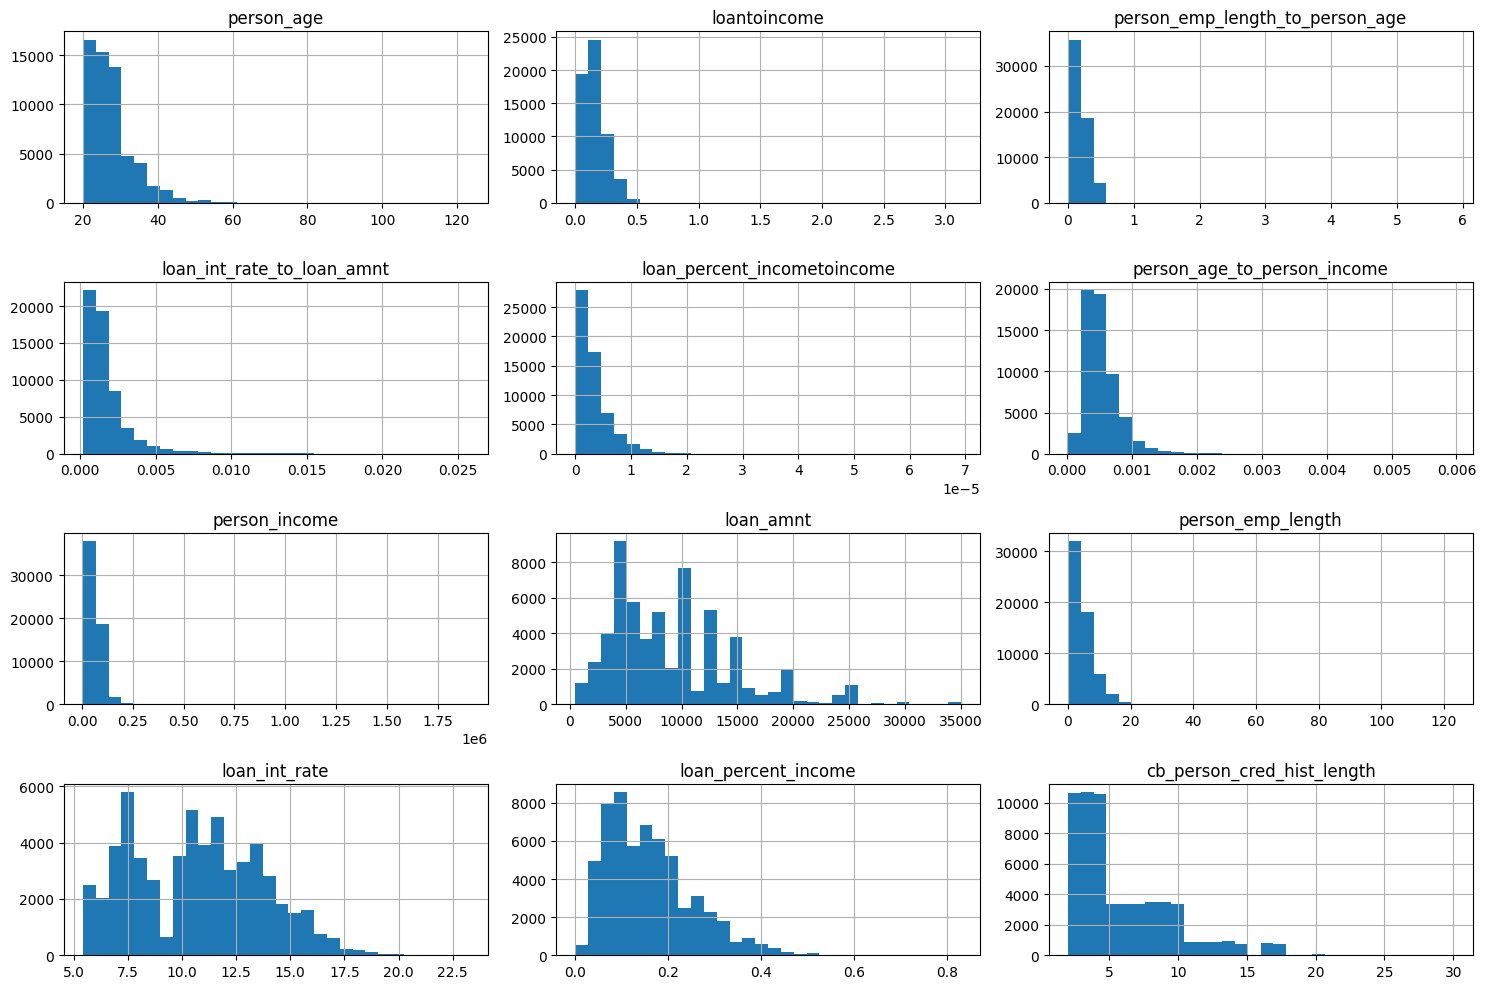

In [ ]:
# train["loantoincome"] = ((train["loan_amnt"] / train["person_income"])).astype('Float64')
# train["loan_percent_incometoincome"] = ((train["loan_percent_income"] / train["person_income"])).astype('Float64')
# train['person_age_to_person_income'] = (train['person_age'] / train['person_income']).astype(str).astype('Float64')
# train['person_emp_length_to_person_age'] = (train['person_emp_length'] / train['person_age']).astype('Float64')
# train['loan_int_rate_to_loan_amnt'] = (train['loan_int_rate'] / train['loan_amnt']).astype('Float64')
# train['person_home_ownership'] = train['person_home_ownership'].replace({'RENT': 0, 'MORTGAGE': 1, 'OWN': 2, 'OTHER': 3}).astype('category')
# train['loan_intent'] = train['loan_intent'].replace({'EDUCATION': 0, 'MEDICAL': 1, 'PERSONAL': 2, 'VENTURE': 3, 'DEBTCONSOLIDATION': 4, 'HOMEIMPROVEMENT': 5}).astype('category')
# train['loan_grade'] = train['loan_grade'].replace({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}).astype('category')
# train['cb_person_default_on_file'] = train['cb_person_default_on_file'].replace({'N': 0, 'Y': 1}).astype('category')

# Plot histograms for numerical columns
numerical_columns = ['person_age','loantoincome','person_emp_length_to_person_age',
                     'loan_int_rate_to_loan_amnt','loan_percent_incometoincome',
                     'person_age_to_person_income','person_income', 'loan_amnt',"person_emp_length" ,
                     'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
train[numerical_columns].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

# Plot count plots for categorical columns
categorical_columns = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file', 'loan_status',
    "person_home_ownership_income"
]

numerical_features = numerical_columns
categorical_features = categorical_columns
fig, axes = plt.subplots(3, 2, figsize=(15, 15))  # Adjusted to 3x2 grid
for ax, col in zip(axes.flatten(), categorical_columns):
    sns.countplot(data=train, x=col, ax=ax)
    ax.set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

features = numerical_columns + categorical_columns 
categorical_columns.remove('loan_status')
features.remove('loan_status')
# Define the preprocessing for numerical and categorical features
#print how many 'load_status' 0 and 1 and find the ratio
print(train['loan_status'].value_counts())
print(train['loan_status'].value_counts(normalize=True))

print()


In [231]:
# print(train.head(4))
print(train.shape)
train.head(4)

(58645, 22)


,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,...,loan_status,loantoincome,loan_percent_incometoincome,person_age_to_person_income,person_emp_length_to_person_age,loan_int_rate_to_loan_amnt,income_to_age,loan_to_income,rate_to_loan,person_home_ownership_income
0,0,37,35000,0,0.0,0,1,6000,11.49,0.17,...,0,0.171429,0.000005,0.001057,0.0,0.001915,945.945946,0.171429,0.001915,0
1,1,22,56000,2,6.0,1,2,4000,13.35,0.07,...,0,0.071429,0.000001,0.000393,0.272727,0.003337,2545.454545,0.071429,0.003337,1
2,2,29,28800,2,8.0,2,0,6000,8.90,0.21,...,0,0.208333,0.000007,0.001007,0.275862,0.001483,993.103448,0.208333,0.001483,2
3,3,30,70000,0,14.0,3,1,12000,11.11,0.17,...,0,0.171429,0.000002,0.000429,0.466667,0.000926,2333.333333,0.171429,0.000926,3


In [232]:
features

['person_age',
 'loantoincome',
 'person_emp_length_to_person_age',
 'loan_int_rate_to_loan_amnt',
 'loan_percent_incometoincome',
 'person_age_to_person_income',
 'person_income',
 'loan_amnt',
 'person_emp_length',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length',
 'person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file',
 'person_home_ownership_income']

In [233]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

target = ['loan_status']  # Replace with the actual target column name

# Preprocess the data
X = train[features]
y = train[target]
ids = train['id']
testx = test[features]
test_ids = test['id']

X.shape , y.shape , testx.shape,  test_ids.shape

((58645, 17), (58645, 1), (39098, 17), (39098,))

In [234]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(X, y, ids, test_size=0.2, random_state=42)

# Define the preprocessing for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # ('onehot', OneHotEncoder(handle_unknown='error'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocess the data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
testx = preprocessor.transform(testx)

# Function to add noise
def add_noise(data, noise_level=0.01):
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

# Add noise to the numerical features
X_train_noisy = X_train.copy()
X_test_noisy = X_test.copy()
X_train_noisy[:, :len(numerical_features)] = add_noise(X_train[:, :len(numerical_features)])
X_test_noisy[:, :len(numerical_features)] = add_noise(X_test[:, :len(numerical_features)])


X_train_less_noise = X_train.copy()
X_test_less_noise = X_test.copy()
X_train_less_noise[:, :len(numerical_features)] = add_noise(X_train[:, :len(numerical_features)],noise_level=0.001)
X_test_less_noise[:, :len(numerical_features)] = add_noise(X_test[:, :len(numerical_features)],noise_level=0.001)

# Concatenate the original data with the noisy data vertically
X_train_combined = np.vstack((X_train, X_train_noisy, X_train_less_noise))
X_test_combined = np.vstack((X_test, X_test_noisy, X_test_less_noise))

# Concatenate the target variable as well
y_train_combined = np.vstack((y_train, y_train, y_train))
y_test_combined = np.vstack((y_test, y_test,y_test))

# Concatenate the ids as well
ids_train_combined = np.hstack((ids_train, ids_train, ids_train))
ids_test_combined = np.hstack((ids_test, ids_test, ids_test))

# Update the original variables
X_train = X_train_combined
X_test = X_test_combined
y_train = y_train_combined
y_test = y_test_combined
ids_train = ids_train_combined
ids_test = ids_test_combined
xult , yult  , idsult= np.vstack((X_train, X_test)), np.vstack((y_train, y_test)) , np.hstack((ids_train, ids_test))
print(X_train.shape)  # Should output (46916 + 46916, 26)
print(X_test.shape)   # Should output (11729 + 11729, 26)
print(y_train.shape)  # Should output (46916 + 46916, 1)
print(y_test.shape)   # Should output (11729 + 11729, 1)
print(ids_train.shape)  # Should output (46916 + 46916,)
print(ids_test.shape)   # Should output (11729 + 11729,)
print(testx.shape)   # Should output (11729 + 11729,)
print(test_ids.shape)   # Should output (11729 + 11729,)
fmax = 0

(140748, 17)
(35187, 17)
(140748, 1)
(35187, 1)
(140748,)
(35187,)
(39098, 17)
(39098,)


In [235]:
import numpy as np
import pandas as pd

class ensemble:
    def __init__(self):
        self.models = []
        
    def add_model(self, model):
        self.models.append(model)
        
    def predict(self, X_test):
        predictions = []
        for model in self.models:
            pred = model.predict(X_test)
            predictions.append(pred)
            count_greater_than_0_5 = (pred > model.THRESHOLD).sum()
            count_less_than_or_equal_0_5 = (pred <= model.THRESHOLD).sum()
            print(f'Percentage of predictions greater than {model.THRESHOLD}: {count_greater_than_0_5 / len(pred) * 100:.2f}%')
            passc = count_greater_than_0_5 / len(pred) * 100
            if passc < 5:
                predictions.pop()
                continue
            print(f'Percentage of predictions less than or equal to {model.THRESHOLD}: {count_less_than_or_equal_0_5 / len(pred) * 100:.2f}%')
        
        # Stack predictions to form a 2D array
        stacked_predictions = np.hstack(predictions)
        
        # Average the predictions across models
        y_pred = np.mean(stacked_predictions, axis=1)
        
        # Apply threshold
        y_pred = (y_pred > 0.5).astype(int)
        
        # Flatten the predictions to form a 1D array
        y_pred = y_pred.flatten()
        
        # Assuming test_ids is defined elsewhere in your code
        ids = test_ids
        predictions_df = pd.DataFrame({'id': ids, 'loan_status': y_pred})
        return predictions_df
    
    def save(self, testx, path="ftt.csv"):
        df = self.predict(testx)
        df.to_csv(path, index=False)
        
    def rmamodel(self):
        self.models = []

ens = ensemble()

In [236]:
def ktrain( model , xult , yult,splits=5,epochs=15,batch_size=32,random_state=42):
    global fmax 
    if splits==1:
        class temp:
            def split(self, X):
                n_samples = len(X)
                indices = list(range(n_samples))
                yield indices, indices  # Use the same indices for train and test

        kf = temp()
    else:
        kf = KFold(n_splits=splits, shuffle=True, random_state=random_state)
        obj = kf 
    losses, aucs, precisions, recalls, f1s, roc_aucs = [], [], [], [], [], []
    for train_index, test_index in kf.split(X):
        xt, xv = xult[train_index], xult[test_index]
        yt, yv = yult[train_index], yult[test_index]
        
        # Initialize and compile the model
        
        # Train the model
        model.fit(xt, yt, epochs=epochs, batch_size=batch_size, verbose=1)
        
        # Evaluate the model
        results = model.evaluate(xv, yv)
        loss, auc, precision, recall = results[0], results[1], results[2], results[3]
        
        # Predict probabilities for the test set
        y_pred_prob = model.predict(xult)
        y_pred = (y_pred_prob > model.THRESHOLD).astype(int)
        
        # Calculate F1 score and ROC AUC score
        f1 = f1_score(yult, y_pred)
        roc_auc = roc_auc_score(yult, y_pred_prob)
        if f1 > fmax:
            fmax = f1
            model.save('best.keras')
            print(colored(f'F1 Score improved to {f1}. Saving model...', 'green','on_red'))
        # Store metrics
        losses.append(loss)
        aucs.append(auc)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        roc_aucs.append(roc_auc)
    print('losses: ', losses)
    print('aucs: ', aucs)
    print('precisions: ', precisions)
    print('recalls: ', recalls)
    print('f1s: ', f1s)
    print('roc_aucs: ', roc_aucs)
    print(f'Average Loss: {sum(losses) / len(losses)}')
    print(f'Average AUC: {sum(aucs) / len(aucs)}')
    print(f'Average Precision: {sum(precisions) / len(precisions)}')
    print(f'Average Recall: {sum(recalls) / len(recalls)}')
    print(f'Average F1 Score: {sum(f1s) / len(f1s)}')
    print(f'Average ROC AUC Score: {sum(roc_aucs) / len(roc_aucs)}')



In [237]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape, Input
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import AUC, Precision, Recall
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from colorama import init
from termcolor import colored
# Define the L2 regularizers


k = .0001
kernel_regularizer = l2(0.0001*k)
bias_regularizer = l2(0.00001*k)

# Define the CNN model with different regularization strengths for kernel and bias
class AutoencoderModel:
    def __init__(self, input_dim, encoding_dim=512):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.autoencoder = self.build_model()
        self.THRESHOLD = 0.5
    def build_model(self):
        # Encoder
        input_layer = Input(shape=(self.input_dim,))
        encoded = Dense(self.encoding_dim, activation='relu')(input_layer)
        encoded = Dense(self.encoding_dim // 2, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(encoded)
        encoded = Dense(self.encoding_dim // 4, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(encoded)
        encoded = Dense(self.encoding_dim // 8, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(encoded)
        encoded = Dense(self.encoding_dim // 16, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(encoded)
        encoded = Dense(self.encoding_dim // 32, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(encoded)
    
        # Decoder
        decoded = Dense(self.encoding_dim // 32, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(encoded)
        decoded = Dense(self.encoding_dim // 16, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(encoded)
        decoded = Dense(self.encoding_dim // 8, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(encoded)
        decoded = Dense(self.encoding_dim // 4, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(decoded)
        decoded = Dense(self.encoding_dim // 2, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(decoded)
        decoded = Dense(1, activation='sigmoid')(decoded)
    
        # Autoencoder
        autoencoder = Model(input_layer, decoded)
    
        # Compile the model with Binary Crossentropy loss
        autoencoder.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=[AUC(), Precision(), Recall()])    
        return autoencoder

    def fit(self, X_train, y_train, epochs=10, verbose=0, batch_size=32, validation_split=0.3, validation_data=None):
        if validation_data is not None:
            self.autoencoder.fit(X_train, y_train, epochs=epochs, verbose=verbose, batch_size=batch_size, validation_data=validation_data, validation_split=validation_split)
            return 
        self.autoencoder.fit(X_train, y_train, epochs=epochs, verbose=verbose, batch_size=batch_size, validation_split=validation_split)

    def predict(self, X_test):
        print(colored(f'Predicting with encoding_dim {self.encoding_dim}...', 'green'))
        return self.autoencoder.predict(X_test)

    def summary(self):
        self.autoencoder.summary()

    def evaluate(self, X_test, y_test):
        return self.autoencoder.evaluate(X_test, y_test)
    def save(self, path):
        self.autoencoder.save(path)

dim = [512, 256, 128, 64, 256]
for i in range(5):
    automodel = AutoencoderModel(X_train.shape[1], encoding_dim=dim[i])
    ktrain(automodel, xult, yult, splits=1, epochs=15, batch_size=32, random_state=i)
    ens.add_model(automodel)


Epoch 1/15


1283/1283 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc_58: 0.7112 - loss: 0.4083 - precision_58: 0.5150 - recall_58: 0.1318 - val_auc_58: 0.8356 - val_loss: 0.3239 - val_precision_58: 0.8043 - val_recall_58: 0.2209
Epoch 2/15
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc_58: 0.8289 - loss: 0.3107 - precision_58: 0.7406 - recall_58: 0.2542 - val_auc_58: 0.8939 - val_loss: 0.2693 - val_precision_58: 0.6844 - val_recall_58: 0.5983
Epoch 3/15
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc_58: 0.8739 - loss: 0.2685 - precision_58: 0.7719 - recall_58: 0.4025 - val_auc_58: 0.8345 - val_loss: 0.3321 - val_precision_58: 0.7408 - val_recall_58: 0.2480
Epoch 4/15
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc_58: 0.8545 - loss: 0.2834 - precision_58: 0.7635 - recall_58: 0.3523 - val_auc_58: 0.8708 - val_loss: 0.2577 - val_precision_58: 0.7675 - val_recall_58: 0.5072
Epoch 5/15
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc_58: 0.8790 - loss: 0.2594 - precision_58: 0.7821 - recall_58: 0.4553 - 

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import AUC, Precision, Recall
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from colorama import init
from termcolor import colored

# Define the L2 regularizers
k = .0001
kernel_regularizer = l2(0.0001*k)
bias_regularizer = l2(0.00001*k)

# Define the Dense model with different regularization strengths for kernel and bias
class DenseModel:
    def __init__(self, input_dim, hidden_dim=64):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.model = self.build_model()
        self.THRESHOLD = 0.5

    def build_model(self):
        input_layer = Input(shape=(self.input_dim,))
        x = Dense(self.hidden_dim, activation='relu')(input_layer)
        x = Dense(self.hidden_dim // 2, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(x)
        x = Dense(self.hidden_dim // 4, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(x)
        x = Dense(self.hidden_dim // 8, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(x)
        x = Dense(self.hidden_dim // 16, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(x)
        x = Dense(self.hidden_dim // 32, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(x)
        output_layer = Dense(1, activation='sigmoid')(x)

        model = Model(input_layer, output_layer)

        # Compile the model with Binary Crossentropy loss
        model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=[AUC(), Precision(), Recall()])
        return model

    def fit(self, X_train, y_train, epochs=10, verbose=0, batch_size=32, validation_split=0.3, validation_data=None):
        if validation_data is not None:
            self.model.fit(X_train, y_train, epochs=epochs, verbose=verbose, batch_size=batch_size, validation_data=validation_data, validation_split=validation_split)
            return 
        self.model.fit(X_train, y_train, epochs=epochs, verbose=verbose, batch_size=batch_size, validation_split=validation_split)

    def predict(self, X_test):
        print(colored(f'predicting using dense model of hidden {self.hidden_dim}', 'green'))
        return self.model.predict(X_test)

    def summary(self):
        self.model.summary()

    def evaluate(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test)

    def save(self, path):
        self.model.save(path)

# Example usage
# Assuming xult and yult are your feature matrix and target vector
for i in range(5):
    dense_model = DenseModel(input_dim=xult.shape[1])
    ktrain(dense_model, xult, yult,epochs=15,batch_size=32,splits=5,random_state=i)
    ens.add_model(dense_model)

2024-10-22 08:29:47.971809: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-22 08:29:47.974963: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-22 08:29:47.984124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 08:29:47.998481: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-22 08:29:48.002727: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-22 08:29:48.014528: I tensorflow/core/platform/cpu_feature_gu

NameError: name 'xult' is not defined

In [239]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score

class XGBoostClassifierModel:
    def __init__(self, eval_metric='logloss', model_path='xgb_model.json', **kwargs):
        self.model = xgb.XGBClassifier(objective='binary:logistic', eval_metric=eval_metric, **kwargs)
        self.model_path = model_path
        self.THRESHOLD = 0.5
        self.load_model()

    def fit(self, X_train, y_train, verbose=0, **kwargs):
        self.model.fit(X_train, y_train, verbose=verbose, xgb_model=self.model_path if self.model_exists() else None)
        self.save_model()

    def predict(self, X_test):
        print(colored('predicting using xgboost model', 'green'))
        return self.model.predict(X_test).reshape(-1, 1)

    def predict_proba(self, X_test):
        return self.model.predict_proba(X_test)[:, 1]

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        y_pred_proba = self.predict_proba(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        # Assuming loss is not directly available, using log loss as a proxy
        loss = -1  # Placeholder, as XGBoost does not directly provide loss in this context
        return [loss, auc, precision, recall]

    def summary(self):
        print(self.model)

    def save_model(self):
        self.model.save_model(self.model_path)

    def load_model(self):
        if self.model_exists():
            self.model.load_model(self.model_path)

    def model_exists(self):
        try:
            with open(self.model_path, 'r'):
                return True
        except FileNotFoundError:
            return False
    def save(self, path):
        self.model.save_model(path)

# Example usage
# Assuming xult and yult are your feature matrix and target vector
# Split the data into training and test sets

for i in range(5):
    if i%2==0:
        xgb_model = XGBoostClassifierModel( model_path=f'xgb_model{i}.json')
    else:
        xgb_model = XGBoostClassifierModel(eval_metric='auc', model_path=f'xgb_model{i}.json')
    ktrain(xgb_model, xult, yult, epochs=10, batch_size=32, splits=5, random_state=i)
    ens.add_model(xgb_model)


predicting using xgboost model
predicting using xgboost model


/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [08:05:41] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


F1 Score improved to 0.952375127420999. Saving model...
predicting using xgboost model
predicting using xgboost model


/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [08:05:44] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


F1 Score improved to 0.9525806780006109. Saving model...
predicting using xgboost model
predicting using xgboost model
predicting using xgboost model
predicting using xgboost model


/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [08:05:51] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


F1 Score improved to 0.952899802817474. Saving model...
predicting using xgboost model
predicting using xgboost model


/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [08:05:55] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


F1 Score improved to 0.953284730990103. Saving model...
losses:  [-1, -1, -1, -1, -1]
aucs:  [0.9999797941675777, 1.0, 0.9999999398384783, 1.0, 1.0]
precisions:  [1.0, 1.0, 0.9993939393939394, 1.0, 1.0]
recalls:  [0.9935408103347034, 1.0, 1.0, 1.0, 1.0]
f1s:  [0.952375127420999, 0.9525806780006109, 0.9525263007956373, 0.952899802817474, 0.953284730990103]
roc_aucs:  [0.964076822991853, 0.9646992861875414, 0.9648857866333145, 0.9654881349737149, 0.9650316704298927]
Average Loss: -1.0
Average AUC: 0.9999959468012112
Average Precision: 0.999878787878788
Average Recall: 0.9987081620669407
Average F1 Score: 0.9527333280049648
Average ROC AUC Score: 0.9648363402432633
predicting using xgboost model
predicting using xgboost model
predicting using xgboost model
predicting using xgboost model
predicting using xgboost model
predicting using xgboost model
predicting using xgboost model
predicting using xgboost model
predicting using xgboost model
predicting using xgboost model
losses:  [-1, -1, -

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [08:06:19] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


F1 Score improved to 0.9599498361584207. Saving model...
predicting using xgboost model
predicting using xgboost model
predicting using xgboost model
predicting using xgboost model


/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [08:06:34] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


F1 Score improved to 0.9599821873165597. Saving model...
predicting using xgboost model
predicting using xgboost model
predicting using xgboost model
predicting using xgboost model
losses:  [-1, -1, -1, -1, -1]
aucs:  [1.0, 1.0, 1.0, 0.9999997609278961, 1.0]
precisions:  [1.0, 0.9993993993993994, 1.0, 0.9987980769230769, 1.0]
recalls:  [1.0, 1.0, 1.0, 1.0, 1.0]
f1s:  [0.9599498361584207, 0.9599449470722772, 0.9599821873165597, 0.9598802274060736, 0.9598348044376063]
roc_aucs:  [0.9714489521801412, 0.9712025714948471, 0.9711925527610651, 0.9713224867493366, 0.9710528322021827]
Average Loss: -1.0
Average AUC: 0.9999999521855791
Average Precision: 0.9996394952644951
Average Recall: 1.0
Average F1 Score: 0.9599184004781876
Average ROC AUC Score: 0.9712438790775145
predicting using xgboost model
predicting using xgboost model
predicting using xgboost model
predicting using xgboost model
predicting using xgboost model
predicting using xgboost model
predicting using xgboost model
predicting u

In [240]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score

class XGBRFClassifierModel:
    def __init__(self, objective='binary:logistic', eval_metric='auc', n_estimators=600, max_depth=5, subsample=0.9,
                 colsample_bynode=0.9, reg_alpha=0.1, reg_lambda=1.0, min_child_weight=1, random_state=42, model_path='xgbrf_model.json', **kwargs):
        self.model = xgb.XGBRFClassifier(objective=objective, eval_metric=eval_metric, n_estimators=n_estimators,
                                         max_depth=max_depth, subsample=subsample, colsample_bynode=colsample_bynode, reg_alpha=reg_alpha,
                                         reg_lambda=reg_lambda, min_child_weight=min_child_weight, random_state=random_state, **kwargs)
        self.model_path = model_path
        self.THRESHOLD = 0.5
        self.load_model()

    def fit(self, X_train, y_train, verbose=0, **kwargs):
        self.model.fit(X_train, y_train, verbose=verbose, xgb_model=self.model_path if self.model_exists() else None)
        self.save_model()

    def predict(self, X_test):
        print(colored('predicting using xgbrf model', 'green'))
        return self.model.predict(X_test).reshape(-1, 1)

    def predict_proba(self, X_test):
        return self.model.predict_proba(X_test)[:, 1]

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        y_pred_proba = self.predict_proba(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        # Assuming loss is not directly available, using log loss as a proxy
        loss = -1  # Placeholder, as XGBoost does not directly provide loss in this context
        return [loss, auc, precision, recall]

    def summary(self):
        print(self.model)

    def save_model(self):
        self.model.save_model(self.model_path)

    def load_model(self):
        if self.model_exists():
            self.model.load_model(self.model_path)

    def model_exists(self):
        try:
            with open(self.model_path, 'r'):
                return True
        except FileNotFoundError:
            return False
    def save(self, path):
        self.model.save_model(path)

for i in range(5):
    if i%2==0:
        xgbrf_model = XGBRFClassifierModel(model_path=f'xgbrf_model{i}.json')
    else:
        xgbrf_model = XGBRFClassifierModel(eval_metric='logloss', model_path=f'xgbrf_model{i}.json')
    ktrain(xgbrf_model, xult, yult, epochs=10, batch_size=32, splits=5, random_state=5)
    ens.add_model(xgbrf_model)


predicting using xgbrf model
predicting using xgbrf model
predicting using xgbrf model
predicting using xgbrf model
predicting using xgbrf model
predicting using xgbrf model
predicting using xgbrf model
predicting using xgbrf model
predicting using xgbrf model
predicting using xgbrf model
losses:  [-1, -1, -1, -1, -1]
aucs:  [0.9590146476843895, 0.9676690808980635, 0.9671616797872485, 0.9699788875859983, 0.970141239954228]
precisions:  [0.9411764705882353, 0.9252336448598131, 0.9396751740139211, 0.9349470499243571, 0.9318181818181818]
recalls:  [0.7219512195121951, 0.7283874923359902, 0.7168141592920354, 0.7202797202797203, 0.7317073170731707]
f1s:  [0.805731332489604, 0.8083455509191384, 0.8095828915608293, 0.8107194374323837, 0.8131739755571531]
roc_aucs:  [0.8512618743028904, 0.8531380444201566, 0.8537397736587666, 0.8545647644962585, 0.8567175262756126]
Average Loss: -1.0
Average AUC: 0.9667931071819854
Average Precision: 0.9345701042409017
Average Recall: 0.7238279816986223
Averag

In [241]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score

class LGBMClassifierModel:
    def __init__(self, eval_metric='logloss', model_path='lgbm_model.txt', **kwargs):
        self.model = lgb.LGBMClassifier(objective='binary', metric=eval_metric, **kwargs)
        self.model_path = model_path
        self.THRESHOLD = 0.5
        self.init_model = None
        self.load_model()

    def fit(self, X_train, y_train, verbose=0, **kwargs):
        self.model.fit(X_train, y_train,   init_model=self.init_model)
        self.save_model()

    def predict(self, X_test):
        ret = self.model.predict(X_test).astype(float)
        # All ret values multiplied by 1.1
        # ret *= 1.1
        print(colored('predicting using lgbm model', 'green'))
        return ret.reshape(-1, 1)

    def predict_proba(self, X_test):
        return self.model.predict_proba(X_test)[:, 1]

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        y_pred_proba = self.predict_proba(X_test)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        # Assuming loss is not directly available, using log loss as a proxy
        loss = -1  # Placeholder, as LightGBM does not directly provide loss in this context
        return [loss, auc, precision, recall]

    def summary(self):
        print(self.model)

    def save_model(self):
        self.model.booster_.save_model(self.model_path)

    def load_model(self):
        if self.model_exists():
            self.init_model = self.model_path

    def model_exists(self):
        try:
            with open(self.model_path, 'r'):
                return True
        except FileNotFoundError:
            return False

    def save(self, path):
        self.model.booster_.save_model(path)

# Example usage
# Assuming xult and yult are your feature matrix and target vector
# Split the data into training and test sets

for i in range(5):
    # Initialize the LightGBM classifier model
    if i % 2 == 0:
        lgbm_model = LGBMClassifierModel(model_path=f'lgbm_model{i}.txt')
    else:
        lgbm_model = LGBMClassifierModel(eval_metric='auc', model_path=f'lgbm_model{i}.txt')
    # Fit the model on training data
    ktrain(lgbm_model, xult, yult, epochs=10, batch_size=32, splits=5, random_state=i)
    ens.add_model(lgbm_model)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 6660, number of negative: 40256
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3334
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 17
predicting using lgbm model
predicting using lgbm model


/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 6728, number of negative: 40188
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3334
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 17
predicting using lgbm model
predicting using lgbm model


/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 6714, number of negative: 40202
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3334
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 17
predicting using lgbm model
predicting using lgbm model


/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 6737, number of negative: 40179
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3334
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 17
predicting using lgbm model
predicting using lgbm model


/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 6613, number of negative: 40303
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3334
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 17
predicting using lgbm model
predicting using lgbm model
losses:  [-1, -1, -1, -1, -1]
aucs:  [0.9990478660356824, 0.9996082088308735, 0.9997796283461838, 0.9999274995224465, 0.9999615764534093]
precisions:  [0.9873096446700508, 0.9923126201153107, 0.993577392421323, 1.0, 1.0]
recalls:  [0.913681738109219, 0.9474006116207951, 0.9381443298969072, 0.9674046740467405, 0.9737142857142858]
f1s:  [0.9132952864087931, 0.9214734497467902, 0.9276659833493703, 0.9346463742166518, 0.9374428084186008]
roc_aucs:  [0.9290437238655207, 0.9356133622009387, 0.9406661892439399, 0.946251078

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 6689, number of negative: 40227
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3334
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 17
predicting using lgbm model
predicting using lgbm model


/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 6689, number of negative: 40227
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3334
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 17
predicting using lgbm model
predicting using lgbm model


/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 6699, number of negative: 40217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3334
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 17
predicting using lgbm model
predicting using lgbm model


/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 6623, number of negative: 40293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3334
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 17
predicting using lgbm model
predicting using lgbm model


/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 6752, number of negative: 40164
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3334
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 17
predicting using lgbm model
predicting using lgbm model
losses:  [-1, -1, -1, -1, -1]
aucs:  [0.9991667097392061, 0.9997357425438463, 0.9998847634605831, 0.9999439613459863, 0.9999799387709203]
precisions:  [0.9923076923076923, 0.994328922495274, 0.9975323874151758, 0.9970501474926253, 1.0]
recalls:  [0.9247311827956989, 0.942652329749104, 0.9717548076923077, 0.9712643678160919, 0.9851024208566108]
f1s:  [0.9200715714135355, 0.9271969681107226, 0.9326766559539212, 0.9358592692828146, 0.9399481058640373]
roc_aucs:  [0.9342160018366685, 0.9400538995574811, 0.94429814989763

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 6659, number of negative: 40257
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3334
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 17
predicting using lgbm model
predicting using lgbm model


/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 6699, number of negative: 40217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3334
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 17
predicting using lgbm model
predicting using lgbm model


/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 6664, number of negative: 40252
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3334
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 17
predicting using lgbm model
predicting using lgbm model


/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 6701, number of negative: 40215
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3334
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 17
predicting using lgbm model
predicting using lgbm model


/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 6729, number of negative: 40187
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3334
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 17
predicting using lgbm model
predicting using lgbm model
losses:  [-1, -1, -1, -1, -1]
aucs:  [0.9999998243827052, 1.0, 1.0, 1.0, 1.0]
precisions:  [1.0, 1.0, 1.0, 1.0, 1.0]
recalls:  [0.9976525821596244, 1.0, 1.0, 1.0, 1.0]
f1s:  [0.9544465875979808, 0.9550133278654911, 0.9551075654724063, 0.9554581216194067, 0.9551865518655187]
roc_aucs:  [0.9627965919240155, 0.9633987854889684, 0.9633820618034237, 0.9639478037661628, 0.9635751124255119]
Average Loss: -1.0
Average AUC: 0.999999964876541
Average Precision: 1.0
Average Recall: 0.9995305164319248
Average F1 Score: 0.955042

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 6689, number of negative: 40227
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3334
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 17
predicting using lgbm model
predicting using lgbm model


/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 6697, number of negative: 40219
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3334
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 17
predicting using lgbm model
predicting using lgbm model


/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 6664, number of negative: 40252
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3334
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 17
predicting using lgbm model
predicting using lgbm model


/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 6688, number of negative: 40228
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3334
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 17
predicting using lgbm model
predicting using lgbm model


/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 6714, number of negative: 40202
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3334
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 17
predicting using lgbm model
predicting using lgbm model
losses:  [-1, -1, -1, -1, -1]
aucs:  [0.9994454039223933, 0.9995958236221052, 0.9999082798690451, 0.9999285648542646, 0.9999764166835119]
precisions:  [0.9935649935649936, 0.9924953095684803, 0.9981785063752276, 0.9975490196078431, 0.9987639060568603]
recalls:  [0.9223416965352449, 0.9525810324129652, 0.9676280164802825, 0.9719402985074627, 0.9799878714372346]
f1s:  [0.919246553719878, 0.9266976277143216, 0.9311532919877216, 0.9357221632644568, 0.9390567917635337]
roc_aucs:  [0.9338337560885783, 0.9400975978255242, 

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 6688, number of negative: 40228
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3334
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 17
predicting using lgbm model
predicting using lgbm model


/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 6712, number of negative: 40204
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3334
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 17
predicting using lgbm model
predicting using lgbm model


/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 6704, number of negative: 40212
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3334
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 17
predicting using lgbm model
predicting using lgbm model


/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 6647, number of negative: 40269
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3334
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 17
predicting using lgbm model
predicting using lgbm model


/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 6701, number of negative: 40215
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3334
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 17
predicting using lgbm model
predicting using lgbm model
losses:  [-1, -1, -1, -1, -1]
aucs:  [0.9987983694022429, 0.9992479014985356, 0.9997800208665921, 0.9998775484643856, 0.9999726860121423]
precisions:  [0.991508817766166, 0.9896305897602073, 0.9919103920348475, 0.9975801572897761, 0.9987730061349693]
recalls:  [0.9062686567164179, 0.9248940036341611, 0.9608197709463532, 0.960955710955711, 0.9795427196149218]
f1s:  [0.9135718965990995, 0.9217102776261078, 0.9271814187068425, 0.9320177725859947, 0.937124815653366]
roc_aucs:  [0.9292033271165193, 0.9359594658977105, 0.

In [242]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score

class LGBMRandomForestClassifierModel:
    def __init__(self, eval_metric='logloss', model_path='lgbm_rf_model.txt', bagging_freq=1, bagging_fraction=0.8, feature_fraction=0.8, **kwargs):
        self.model_path = model_path
        self.model = lgb.LGBMClassifier(boosting_type='rf', objective='binary', metric=eval_metric,
                                        bagging_freq=bagging_freq, bagging_fraction=bagging_fraction,
                                        feature_fraction=feature_fraction, **kwargs)
        self.THRESHOLD = 0.5
        self.load_model()  # Load the saved model if available

    def fit(self, X_train, y_train, verbose=0, **kwargs):
        # Train model from scratch
        self.model.fit(X_train, y_train)
        self.save_model()  # Save model state after training

    def predict(self, X_test):
        print(colored('predicting using lgbm_rf model', 'green'))
        ret = self.model.predict(X_test).astype(float)
        return ret.reshape(-1, 1)

    def predict_proba(self, X_test):
        return self.model.predict_proba(X_test)[:, 1]

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        y_pred_proba = self.predict_proba(X_test)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        loss = -1  # Placeholder for loss
        return [loss, auc, precision, recall]

    def summary(self):
        print(self.model)

    def save_model(self):
        self.model.booster_.save_model(self.model_path)

    def load_model(self):
        if self.model_exists():
            # Load the booster and convert to LGBMClassifier
            booster = lgb.Booster(model_file=self.model_path)
            self.model._Booster = booster  # Inject the booster into the LGBMClassifier

    def model_exists(self):
        try:
            with open(self.model_path, 'r'):
                return True
        except FileNotFoundError:
            return False

# Assuming xult and yult are your feature matrix and target vector
# Split the data into training and test sets

# yyyyyyy.shape 
for i in range(5):
    # Initialize the LightGBM classifier model
    if i % 2 == 0:
        lgbm_rf_model = LGBMRandomForestClassifierModel(model_path=f'lgbm_rf_model{i}.txt')
    else:
        lgbm_rf_model = LGBMRandomForestClassifierModel(eval_metric='auc', model_path=f'lgbm_rf_model{i}.txt')
    # Fit the model on training data
    ktrain(lgbm_rf_model, xult, yult, epochs=1, batch_size=32, splits=5, random_state=i)
    ens.add_model(lgbm_rf_model)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6660, number of negative: 40256
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Light

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


predicting using lgbm_rf model
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
predicting using lgbm_rf model
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6728, number of negative: 40188
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3334
[LightGBM] [Info] Number of data poi

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6714, number of negative: 40202
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Light

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6737, number of negative: 40179
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3334
[LightGBM] [Info] Number of data poi

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6613, number of negative: 40303
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Light

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


predicting using lgbm_rf model
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
predicting using lgbm_rf model
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6689, number of negative: 40227
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Light

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6699, number of negative: 40217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Light

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6623, number of negative: 40293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Light

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6752, number of negative: 40164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3334
[LightGBM] [Info] Number of data poi

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


predicting using lgbm_rf model
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
predicting using lgbm_rf model
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6699, number of negative: 40217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Light

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6664, number of negative: 40252
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3334
[LightGBM] [Info] Number of data poi

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6701, number of negative: 40215
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3334
[LightGBM] [Info] Number of data poi

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6729, number of negative: 40187
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Light

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


predicting using lgbm_rf model
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
predicting using lgbm_rf model
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6697, number of negative: 40219
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Light

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6664, number of negative: 40252
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Light

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6688, number of negative: 40228
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Light

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6714, number of negative: 40202
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Light

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


predicting using lgbm_rf model
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
predicting using lgbm_rf model
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6712, number of negative: 40204
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Light

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6704, number of negative: 40212
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Light

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6647, number of negative: 40269
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Light

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6701, number of negative: 40215
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3334
[LightGBM] [Info] Number of data poi

In [243]:
ens.save(testx, 'finals.csv')

Predicting with encoding_dim 512...
1050/1222 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step

1222/1222 ━━━━━━━━━━━━━━━━━━━━ 1s 870us/step
Percentage of predictions greater than 0.5: 10.69%
Percentage of predictions less than or equal to 0.5: 89.31%
Predicting with encoding_dim 256...
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 1s 738us/step
Percentage of predictions greater than 0.5: 8.63%
Percentage of predictions less than or equal to 0.5: 91.37%
Predicting with encoding_dim 128...
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 1s 673us/step
Percentage of predictions greater than 0.5: 10.93%
Percentage of predictions less than or equal to 0.5: 89.07%
Predicting with encoding_dim 64...
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 1s 666us/step
Percentage of predictions greater than 0.5: 12.00%
Percentage of predictions less than or equal to 0.5: 88.00%
Predicting with encoding_dim 256...
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 1s 719us/step
Percentage of predictions greater than 0.5: 10.56%
Percentage of predictions less than or equal to 0.5: 89.44%
predicting using dense model of hidden 64
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 1s 65